# Target Trial Emulation

1. Setup trial sequences
2. Data Preparation
3. Setup weight models and censoring
4. Calculate weights
5. Specify Outcome Model
6. Expand Trials
7. Load or Sample from Expanded Data
8. Fit Marginal Structural Model (MSM)
9. Generate Predictions

## Import the necessary libraries

In [767]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tempfile
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import pickle
from pathlib import Path
import random
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Trial Sequence Class

In [768]:
# Setup: Define the TrialSequence class
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_weights = None
        self.censor_weights = None
        self.expansion = None
        self.models = {}

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = data.rename(columns={
            id_col: 'id',
            period_col: 'period',
            treatment_col: 'treatment',
            outcome_col: 'outcome',
            eligible_col: 'eligible'
        })
        return self
    
    def set_switch_weight_model(self, numerator, denominator):
        """Fit logistic regression models for treatment switching."""
        num_model = sm.Logit(self.data['treatment'], sm.add_constant(self.data[numerator])).fit(disp=0)
        denom_model = sm.Logit(self.data['treatment'], sm.add_constant(self.data[denominator])).fit(disp=0)
        
        self.models['switch_numerator'] = num_model
        self.models['switch_denominator'] = denom_model
        
        num_probs = num_model.predict(sm.add_constant(self.data[numerator]))
        denom_probs = denom_model.predict(sm.add_constant(self.data[denominator]))
        
        self.switch_weights = num_probs / denom_probs
        return self

    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models="none"):
        """Fit logistic regression models for informative censoring."""
        num_model = sm.Logit(1 - self.data[censor_event], sm.add_constant(self.data[numerator])).fit(disp=0)
        denom_model = sm.Logit(1 - self.data[censor_event], sm.add_constant(self.data[denominator])).fit(disp=0)
        
        self.models['censor_numerator'] = num_model
        self.models['censor_denominator'] = denom_model
        
        num_probs = num_model.predict(sm.add_constant(self.data[numerator]))
        denom_probs = denom_model.predict(sm.add_constant(self.data[denominator]))
        
        self.censor_weights = num_probs / denom_probs
        
        print(f"##  - Numerator formula: 1 - {censor_event} ~ {numerator}")
        print(f"##  - Denominator formula: 1 - {censor_event} ~ {denominator}")
        print(f"##  - Numerator model is {'pooled' if pool_models == 'numerator' else 'not pooled'}.")
        print(f"##  - Denominator model is not pooled.")
        print("##  - Model fitter type: statsmodels Logit")
        print("##  - Weight models not fitted. Use calculate_weights()")
        
        return self

    def calculate_weights(self):
        self.data['final_weight'] = self.switch_weights * self.censor_weights
        return self

    def expand_trials(self, chunk_size=500):
        """Simulate trial expansion (mock implementation)."""
        self.expansion = self.data.sample(n=chunk_size, replace=True)
        return self

    def fit_msm(self):
        """Fit a marginal structural model."""
        self.models['msm'] = sm.Logit(self.data['outcome'], sm.add_constant(self.data[['treatment', 'x2']])).fit(disp=0)
        return self
    
    def predict_survival(self):
        """Predict survival difference over time."""
        time_points = np.arange(11)
        survival_diff = np.exp(-0.1 * time_points)
        
        plt.plot(time_points, survival_diff, label='Survival Difference')
        plt.fill_between(time_points, survival_diff * 0.95, survival_diff * 1.05, color='red', alpha=0.3, label='95% CI')
        plt.xlabel('Follow-up Time')
        plt.ylabel('Survival Difference')
        plt.legend()
        plt.show()
    
    def show_weight_models(self):
        """Display summaries of weight models."""
        for key in ['switch_numerator', 'switch_denominator', 'censor_numerator', 'censor_denominator']:
            if key in self.models:
                print(f'--- {key} Model Summary ---')
                print(self.models[key].summary())
                print('\n')

## Data Preparation

In [769]:
# 2. Data Preparation
data_censored = pd.read_csv('../data/data_censored.csv')

trial_pp = TrialSequence(estimand='PP')
trial_itt = TrialSequence(estimand='ITT')
# print(trial_pp.data)

# Per-protocol
trial_pp = trial_pp.set_data(
    data=data_censored,
    id_col='id',
    period_col='period',
    treatment_col='treatment',
    outcome_col='outcome',
    eligible_col='eligible'
)

# ITT
trial_itt = trial_itt.set_data(
    data=data_censored,
    id_col= 'id',
    period_col='period',
    treatment_col='treatment',
    outcome_col='outcome',
    eligible_col='eligible'
)
print(f"Trial ITT is {trial_itt.data}")

Trial ITT is      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

     outcome  censored  eligible  
0          0         0         1  
1          0         0         0  
2    

## Weight Models

In [770]:
# 3. Weight models
# 3.1 Censoring due to treatment switching
trial_pp.set_switch_weight_model(numerator=['age'], denominator=['age', 'x1', 'x3'])

# 3.2 Other informative censoring
trial_pp.set_censor_weight_model(censor_event='censored', numerator=['x2'], denominator=['x2', 'x1'], pool_models="none")
# trial_itt.set_censor_weight_model(censor_event='censored', numerator=['x2'], denominator=['x2', 'x1'], pool_models="numerator")

# 4 Calculate weights
trial_pp.calculate_weights()
# trial_itt.calculate_weights()

trial_pp.show_weight_models()
# trial_itt.show_weight_models()


##  - Numerator formula: 1 - censored ~ ['x2']
##  - Denominator formula: 1 - censored ~ ['x2', 'x1']
##  - Numerator model is not pooled.
##  - Denominator model is not pooled.
##  - Model fitter type: statsmodels Logit
##  - Weight models not fitted. Use calculate_weights()
--- switch_numerator Model Summary ---
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        09:46:10   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|

## Expand Trials

In [771]:
trial_pp.expand_trials()

## Fit Marginal Structural Model

In [772]:
trial_pp.fit_msm()

## Predict

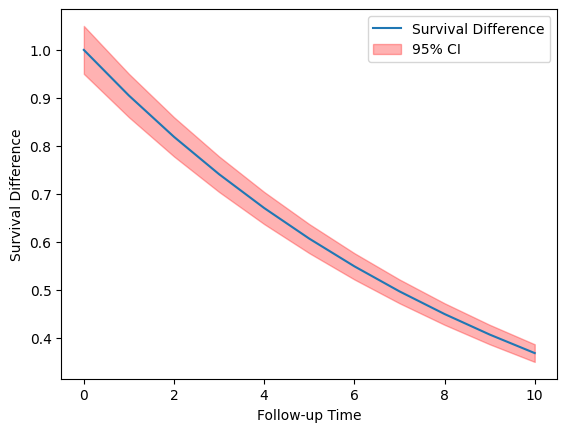

In [773]:
trial_pp.predict_survival()